Carregamento e preparação dos dados (Dataset Spotify)

Análise exploratória inicial:
Shape do dataset: (114000, 20)
Gêneros únicos: 114
Distribuição dos gêneros:
track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
pop-film             1000
piano                1000
party                1000
pagode               1000
opera                1000
Name: count, dtype: int64

Foram removidas 450 linhas duplicadas

Generos da coluna 'track_genre' divididos em super generos:
super_genre
Rock/Metal               20975
Eletrônica               20921
Outros                   18867
Latino/Brasil            12976
Pop                       9983
Mundo/Étnico              9946
Jazz/Blues/Soul/Funk      7992
Clássico/Instrumental     5920
Country/Folk              3979
Hip-Hop/Rap               1991
Name: count, dtype: int64

Features numéricas utilizadas: ['danceability', 'energy', 'valence', 'acousticness', 'speec

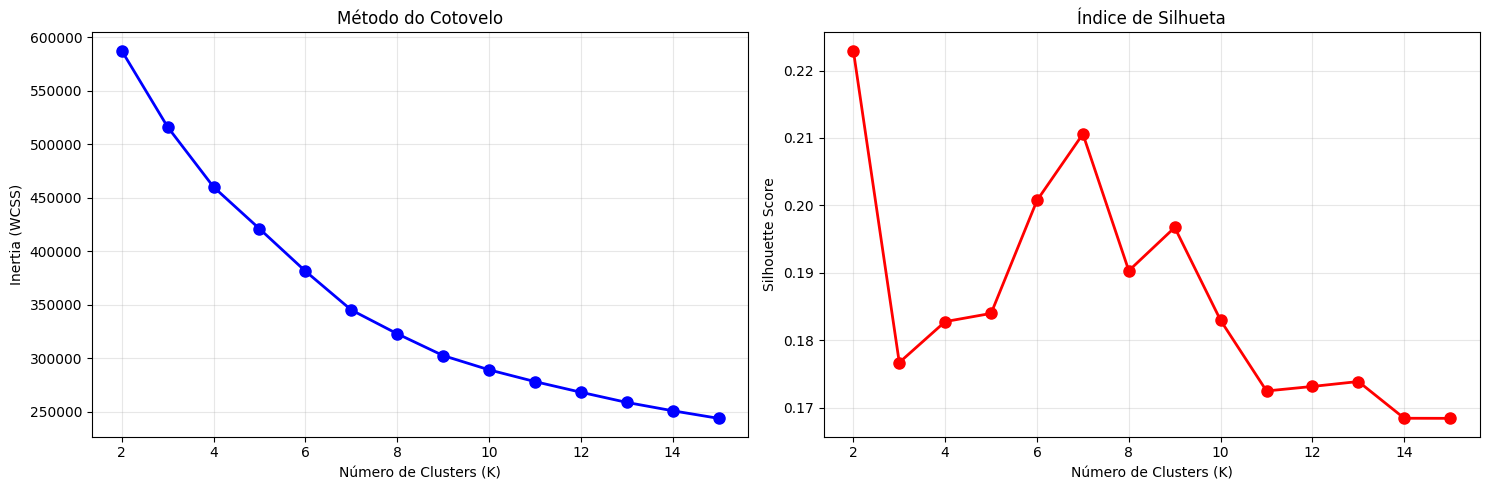


K ótimo baseado no Silhouette Score: 2
K escolhido para análise: 7

Aplicando K-Médias com K=7:
Distribuição dos clusters no treino: [17876  6211 21060  5906 29783  9108   896]


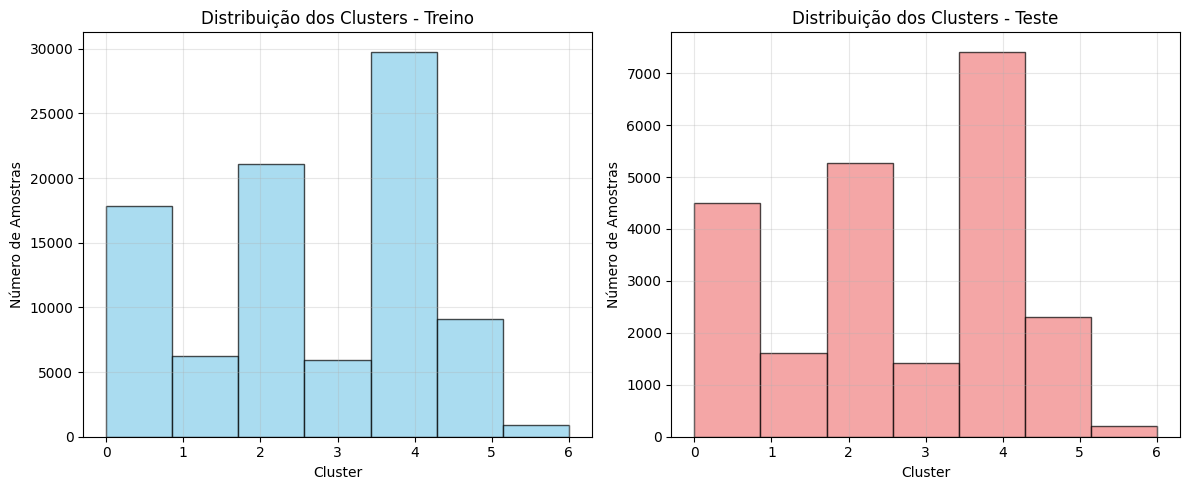


Criação de novas features baseadas nos clusters:
Features originais: 8
Features expandidas: 9
Nova feature: distância ao centroide do cluster mais próximo

Estatísticas das distâncias aos clusters:
Média: 1.840
Desvio padrão: 0.646
Min: 0.287
Max: 6.448

Criação de amostras estratificadas para treino (tamanho 10000):
Tamanho da amostra de treino: 4994 de 90840
Distribuição original: [ 4736  3183 16737  1593  6393 10381  7957 15094  7986 16780]
Distribuição da amostra: [260 175 921  87 351 571 437 830 439 923]

Início do treinamento e avaliação dos modelos de ML..

Treinando modelo SVM com diferentes configurações:

Otimizando SVM_GridSearch com features Original...
  • Melhores parâmetros: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
  • Melhor score CV (F1-macro): 0.262
  • Teste - Acurácia: 0.396, F1: 0.269, AUC: 0.744

Otimizando SVM_GridSearch com features Expandidas...
  • Melhores parâmetros: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
  • Melhor score CV (F1-macro): 0.260


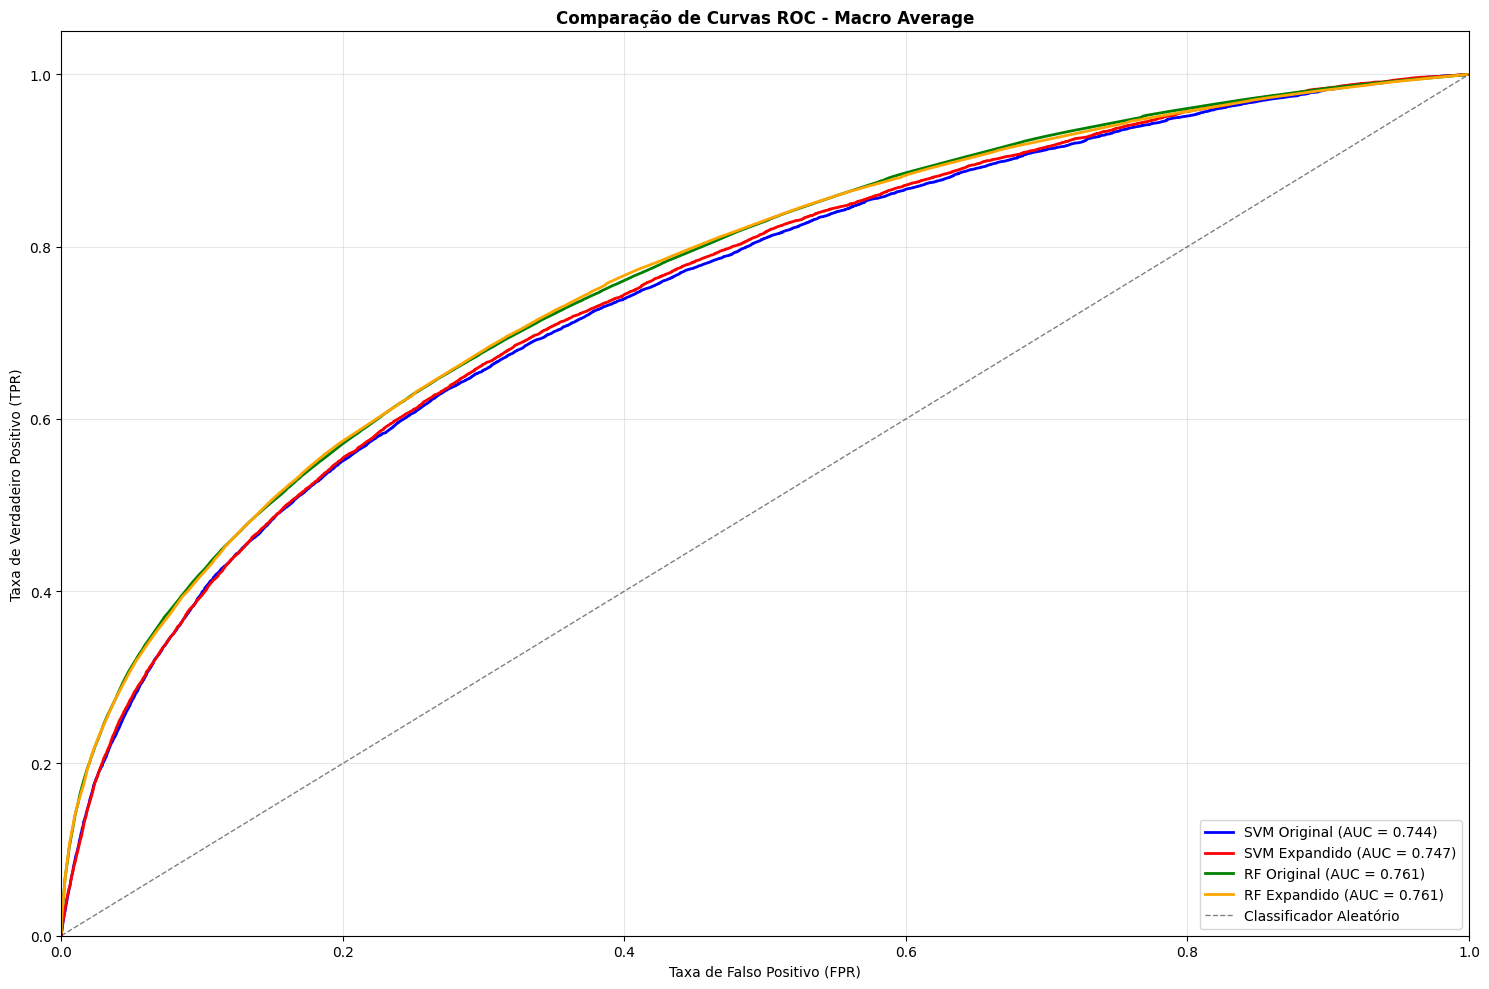

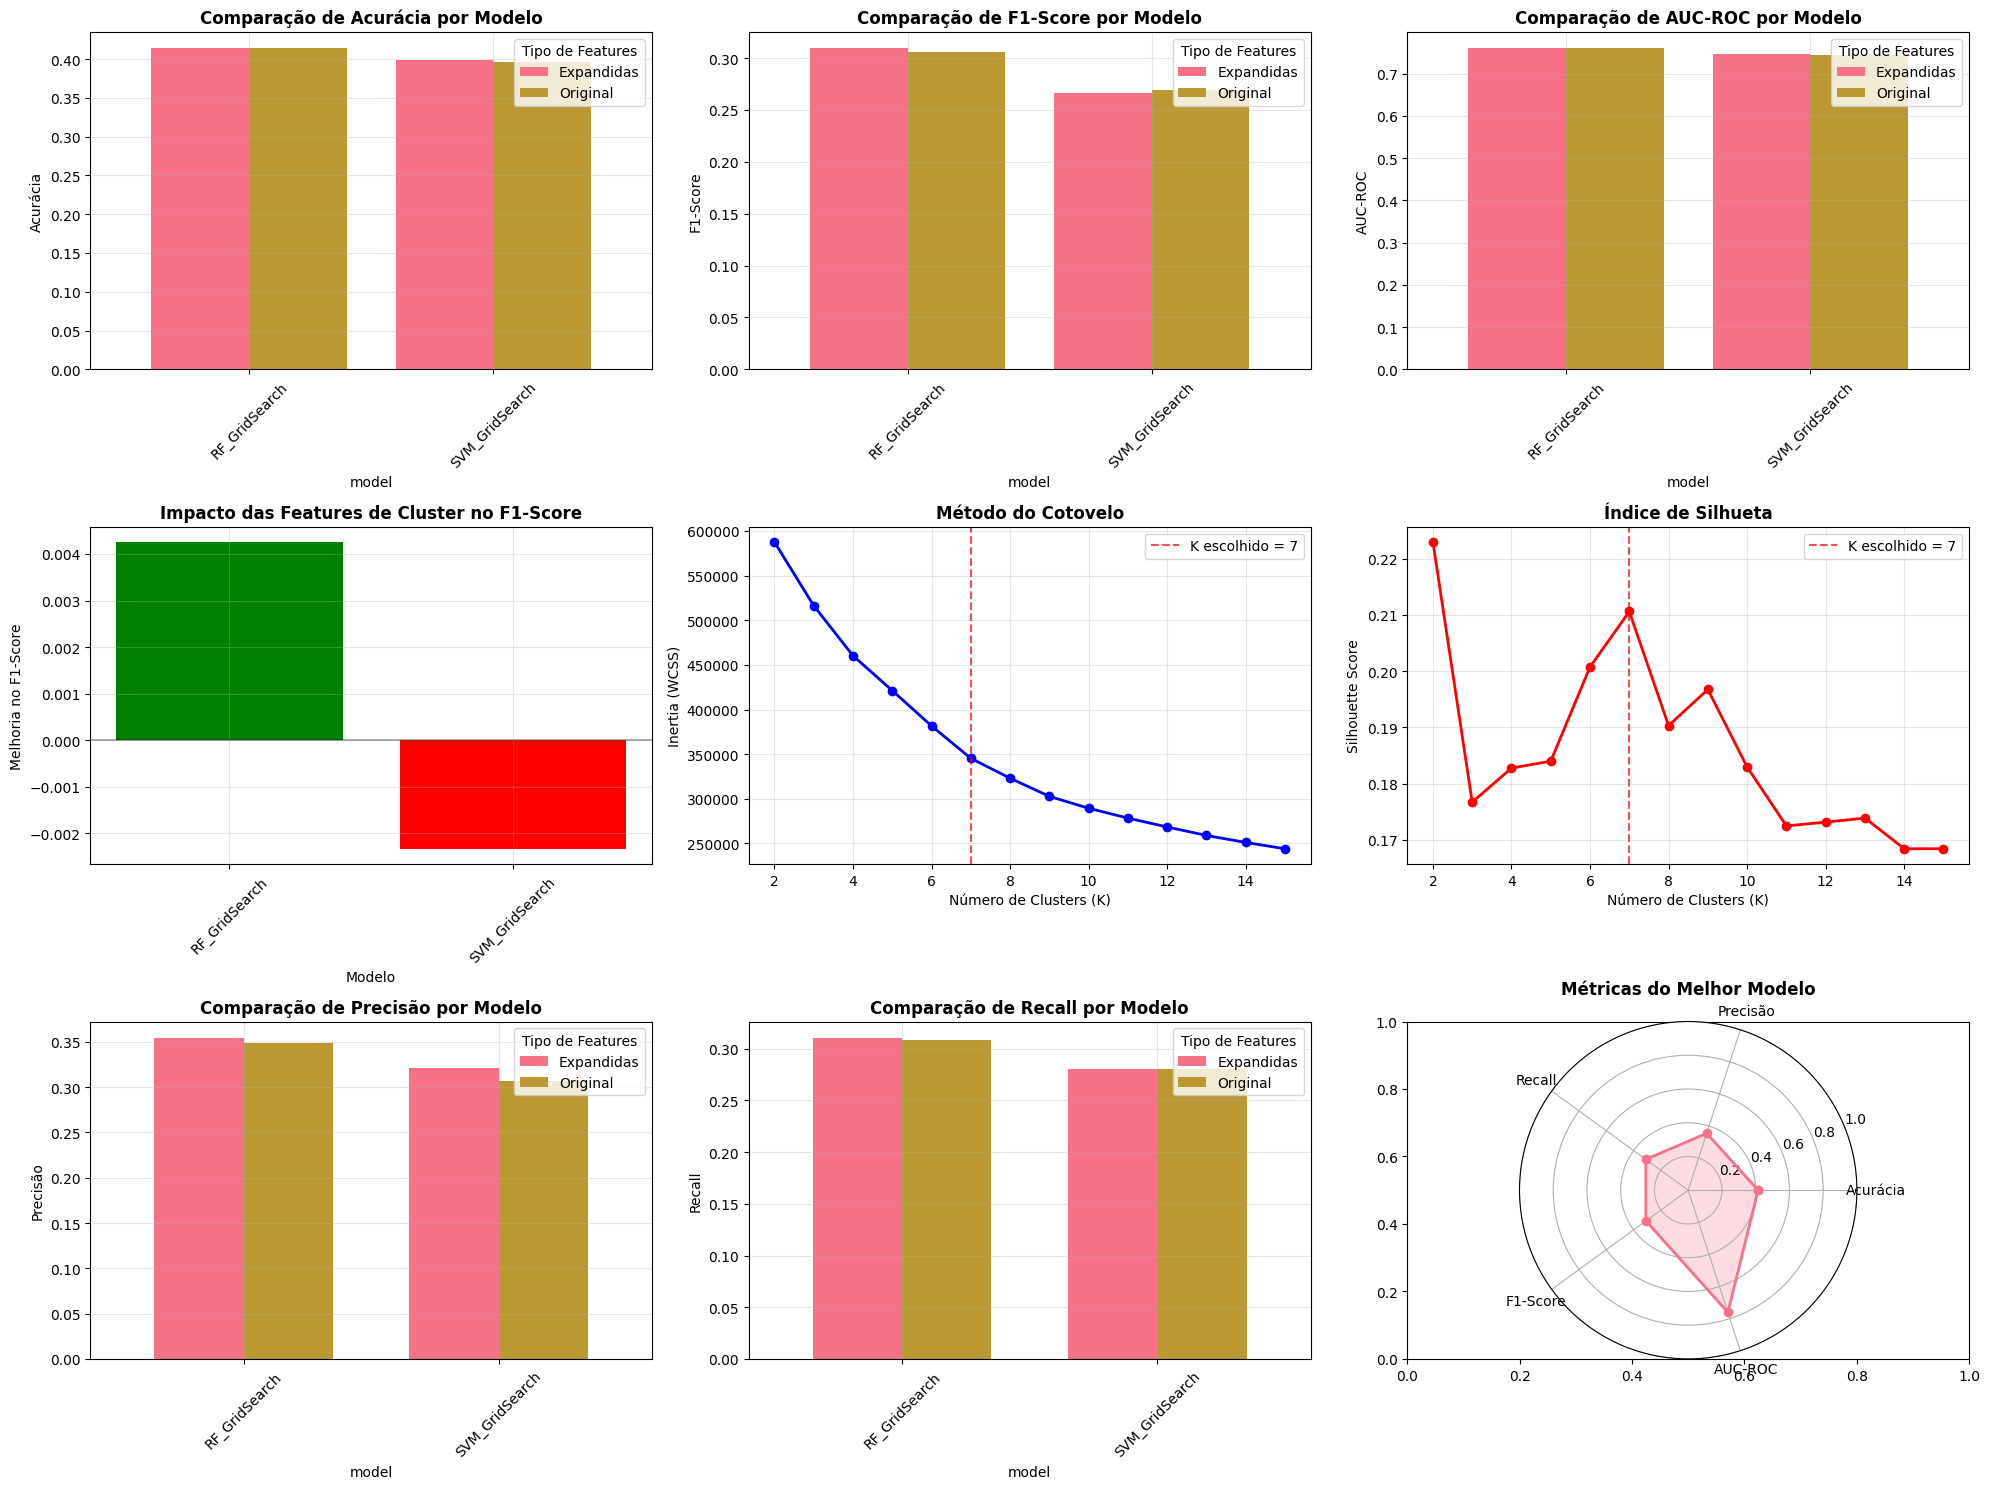


• Análise detalhada dos melhores modelos:

Análise do melhor modelo: RF_GridSearch (Expandidas)


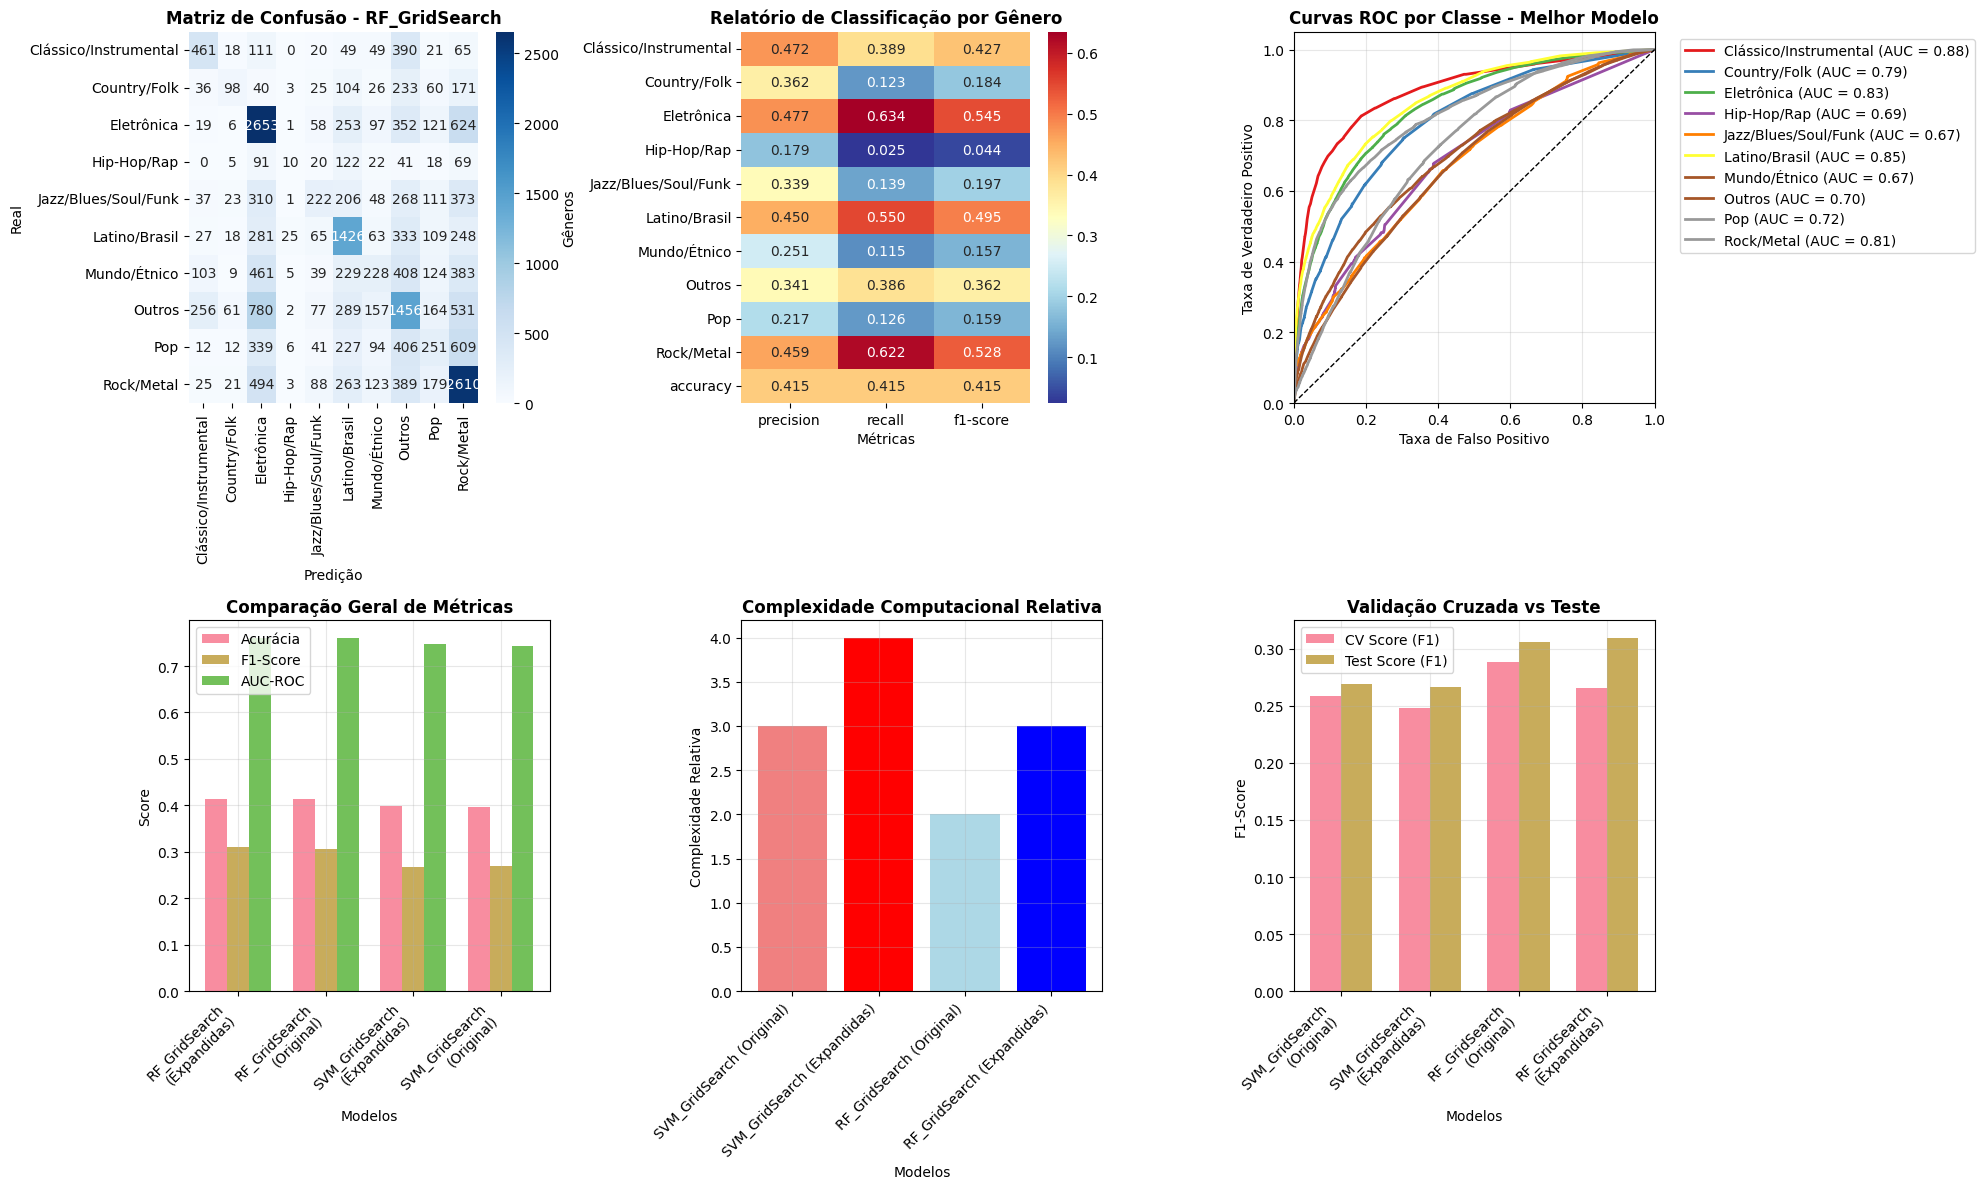


•Resumo dos resultados dos modelos testados:

Resumo dos Resultados com GridSearchCV:
        Modelo   Features                                              Melhores Parâmetros Acurácia Precisão Recall F1-Score AUC-ROC
SVM_GridSearch   Original                   {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}    0.396    0.306  0.281    0.269   0.744
SVM_GridSearch Expandidas                   {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}    0.399    0.321  0.280    0.266   0.747
 RF_GridSearch   Original {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}    0.414    0.348  0.308    0.306   0.761
 RF_GridSearch Expandidas {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}    0.415    0.355  0.311    0.310   0.761

• Análise de Importância das Features (Random Forest)

Importância da feature 'cluster_distance': 0.097
Ranking da feature de cluster: 8º lugar


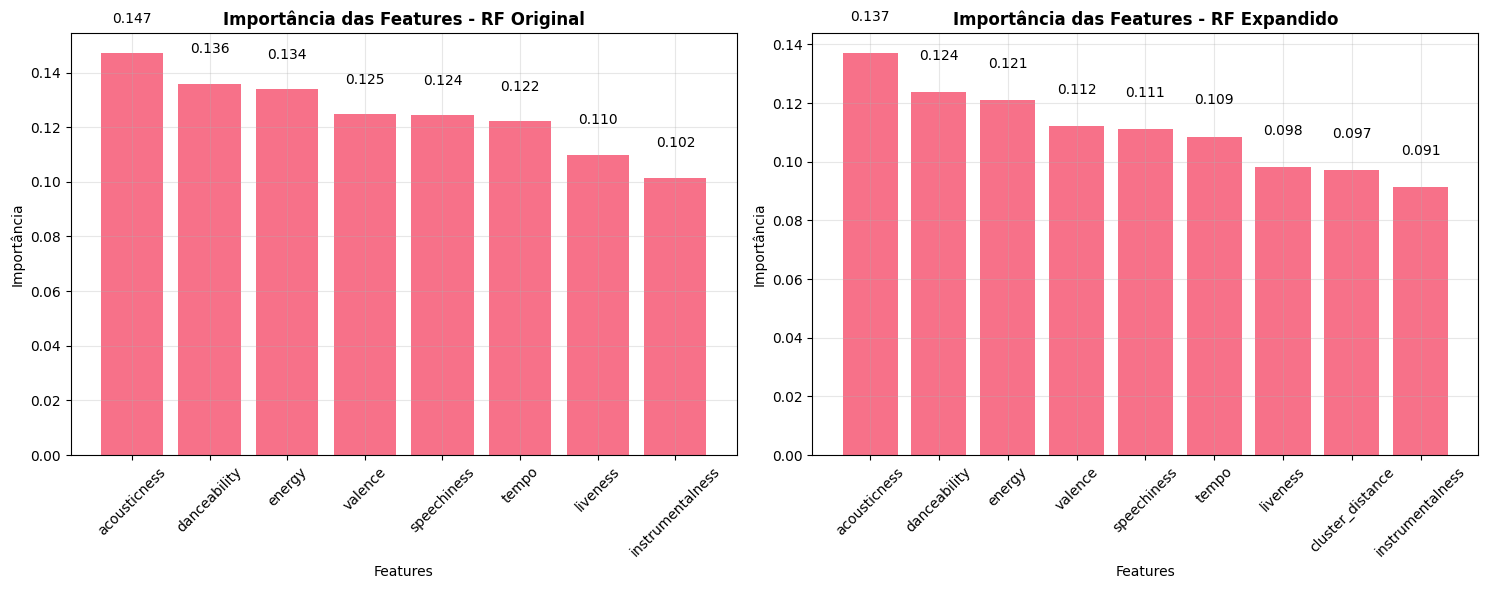


• Análise do impacto das Features de Cluster

Análise de Melhoria com Features de Cluster:
        Modelo F1_Original F1_Expandido Melhoria Melhoria_%
SVM_GridSearch       0.269        0.266   -0.002      -0.9%
 RF_GridSearch       0.306        0.310    0.004       1.4%


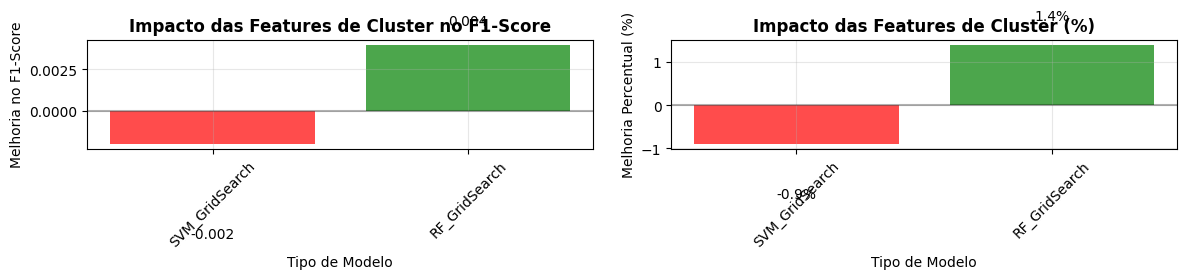


• Análise dos Clusters Formados

Características médias dos clusters:
 Cluster  Tamanho  Danceability  Energy  Valence  Acousticness  Speechiness  Instrumentalness  Liveness  Tempo
       0    17876        -0.267  -1.073   -0.383         1.133       -0.317            -0.437    -0.300 -0.333
       1     6211        -0.281   0.422    0.120        -0.074        0.023            -0.273     2.770  0.025
       2    21060        -0.539   0.661   -0.374        -0.718       -0.005            -0.404    -0.114  0.636
       3     5906        -1.146  -1.795   -1.042         1.633       -0.316             2.224    -0.319 -0.595
       4    29783         0.794   0.300    0.840        -0.308        0.075            -0.443    -0.256 -0.171
       5     9108         0.107   0.461   -0.524        -0.685       -0.118             2.031    -0.220  0.175
       6      896         0.037   0.117   -0.122         1.234        7.039            -0.466     2.312 -0.659


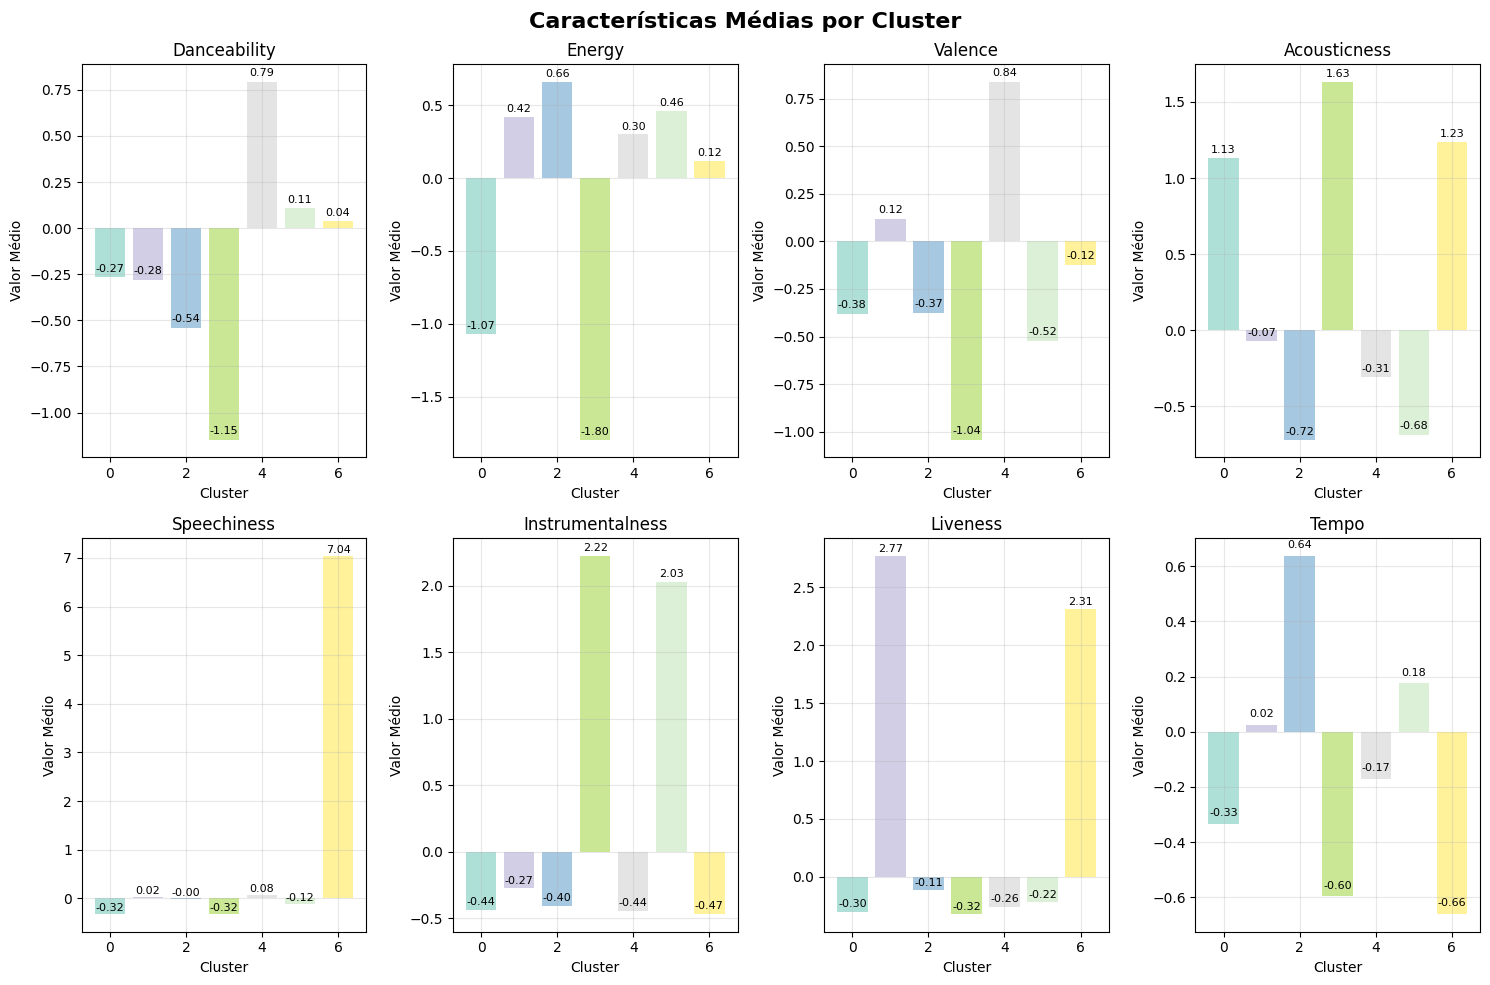

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import cluster, svm, ensemble, preprocessing, model_selection, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo para gráficos
plt.style.use('default')
sns.set_palette("husl")

print("Carregamento e preparação dos dados (Dataset Spotify)")

df = pd.read_csv("./data/dataset.csv", index_col=0)

# Análise exploratória inicial
print("\nAnálise exploratória inicial:")
print(f"Shape do dataset: {df.shape}")
print(f"Gêneros únicos: {df['track_genre'].nunique()}")
print(f"Distribuição dos gêneros:")
print(df['track_genre'].value_counts().head(10))

# Remove colunas duplicadas
len_df_before = len(df)
df = df.drop_duplicates()
len_df_after = len(df)

if (len_df_before != len_df_after):
    print(f"\nForam removidas {len_df_before - len_df_after} linhas duplicadas")

# Cria uma nova coluna 'super_genre' baseada em agrupamentos de gêneros
# Para reduzir a complexidade do problema de classificação
# dicionário de agrupamento
genre_map = {
    # Pop
    'pop': 'Pop', 'synth-pop': 'Pop', 'indie-pop': 'Pop', 'k-pop': 'Pop',
    'j-pop': 'Pop', 'pop-film': 'Pop', 'power-pop': 'Pop', 'electro-pop': 'Pop',
    'cantopop': 'Pop', 'mandopop': 'Pop', 'j-idol': 'Pop',

    # Rock / Metal
    'rock': 'Rock/Metal', 'alt-rock': 'Rock/Metal', 'indie': 'Rock/Metal',
    'hard-rock': 'Rock/Metal', 'punk': 'Rock/Metal', 'punk-rock': 'Rock/Metal',
    'psych-rock': 'Rock/Metal', 'heavy-metal': 'Rock/Metal', 'black-metal': 'Rock/Metal',
    'death-metal': 'Rock/Metal', 'metal': 'Rock/Metal', 'metalcore': 'Rock/Metal',
    'grindcore': 'Rock/Metal', 'rock-n-roll': 'Rock/Metal', 'rockabilly': 'Rock/Metal',
    'grunge': 'Rock/Metal', 'goth': 'Rock/Metal', 'emo': 'Rock/Metal',
    'j-rock': 'Rock/Metal', 'industrial': 'Rock/Metal', 'hardcore': 'Rock/Metal',

    # Hip-Hop / R&B
    'hip-hop': 'Hip-Hop/Rap', 'rap': 'Hip-Hop/Rap', 'trap': 'Hip-Hop/Rap',
    'r-n-b': 'Hip-Hop/Rap',

    # Eletrônica / Dance
    'edm': 'Eletrônica', 'electronic': 'Eletrônica', 'dance': 'Eletrônica',
    'house': 'Eletrônica', 'deep-house': 'Eletrônica', 'progressive-house': 'Eletrônica',
    'trance': 'Eletrônica', 'techno': 'Eletrônica', 'minimal-techno': 'Eletrônica',
    'electro': 'Eletrônica', 'club': 'Eletrônica', 'dubstep': 'Eletrônica',
    'drum-and-bass': 'Eletrônica', 'detroit-techno': 'Eletrônica',
    'breakbeat': 'Eletrônica', 'idm': 'Eletrônica', 'j-dance': 'Eletrônica',
    'dancehall': 'Eletrônica', 'garage': 'Eletrônica', 'hardstyle': 'Eletrônica',
    'trip-hop': 'Eletrônica',

    # Jazz / Blues / Soul / Funk
    'jazz': 'Jazz/Blues/Soul/Funk', 'blues': 'Jazz/Blues/Soul/Funk',
    'soul': 'Jazz/Blues/Soul/Funk', 'funk': 'Jazz/Blues/Soul/Funk',
    'groove': 'Jazz/Blues/Soul/Funk', 'ska': 'Jazz/Blues/Soul/Funk',
    'bluegrass': 'Jazz/Blues/Soul/Funk', 'disco': 'Jazz/Blues/Soul/Funk',

    # Latino / Brasil
    'latin': 'Latino/Brasil', 'latino': 'Latino/Brasil', 'samba': 'Latino/Brasil',
    'pagode': 'Latino/Brasil', 'forro': 'Latino/Brasil', 'mpb': 'Latino/Brasil',
    'bossa nova': 'Latino/Brasil', 'brazil': 'Latino/Brasil',
    'salsa': 'Latino/Brasil', 'reggaeton': 'Latino/Brasil',
    'tango': 'Latino/Brasil', 'sertanejo': 'Latino/Brasil',
    'reggae': 'Latino/Brasil', 'afrobeat': 'Latino/Brasil',

    # Country / Folk
    'country': 'Country/Folk', 'honky-tonk': 'Country/Folk',
    'folk': 'Country/Folk', 'guitar': 'Country/Folk',

    # Clássico / Instrumental
    'classical': 'Clássico/Instrumental', 'opera': 'Clássico/Instrumental',
    'piano': 'Clássico/Instrumental', 'instrumental': 'Clássico/Instrumental',
    'study': 'Clássico/Instrumental', 'sleep': 'Clássico/Instrumental',
    'show-tunes': 'Clássico/Instrumental',

    # Mundo / Étnico
    'world-music': 'Mundo/Étnico', 'indian': 'Mundo/Étnico', 'iranian': 'Mundo/Étnico',
    'turkish': 'Mundo/Étnico', 'malay': 'Mundo/Étnico', 'spanish': 'Mundo/Étnico',
    'french': 'Mundo/Étnico', 'swedish': 'Mundo/Étnico', 'german': 'Mundo/Étnico',
    'british': 'Mundo/Étnico',
}

# aplicar o mapeamento na sua coluna
mapped_genres = list(genre_map.keys())
df['super_genre'] = df['track_genre'].apply(
    lambda x: genre_map[x] if x in mapped_genres else 'Outros'
)

# verificar distribuição
print("\nGeneros da coluna 'track_genre' divididos em super generos:")
print(df['super_genre'].value_counts())

# Remove colunas categóricas que não serão usadas
df = df.drop(columns=["track_name", "track_id", "artists", "album_name", "track_genre"])

# Features numéricas selecionadas para análise
features = ['danceability', 'energy', 'valence', 'acousticness', 
           'speechiness', 'instrumentalness', 'liveness', 'tempo']

# Preparação dos dados usados na modelagem
X = df[features]

# Codificação das labels do target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["super_genre"])
genre_names = label_encoder.classes_

print(f"\nFeatures numéricas utilizadas: {features}")
print(f"Classes identificadas: {genre_names}")

# 1) CLUSTERIZAÇÃO COM K-MÉDIAS

print("\nDivisão dos dados em treino e teste (80% treino, 20% teste)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

print("\nNormalização dos dados com StandardScaler:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Média das features de treino após normalização: {np.mean(X_train_scaled, axis=0).round(3)}")
print(f"Desvio padrão das features de treino após normalização: {np.std(X_train_scaled, axis=0).round(3)}")

print("\nDeterminação do número ótimo de clusters (K) usando K-Médias:")

# Método do Cotovelo (Elbow Method) e Silhouette Score
k_range = range(2, 16)
inertias = []
silhouette_scores = []

print("Calculando métricas para diferentes valores de K:")

# Cria uma amostra de tamanho 20000 para o cálculo da silhueta (mais eficiente)
# Sem a amostra ele fica extremamente lento comprometendo a execução do código
sample_size = min(20000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[sample_indices]

for k in k_range:
    kmeans = cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Inertia com o conjunto completo de treino
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    
    # Silhouette com a amostra
    labels_sample = kmeans.predict(X_sample)
    silhouette_avg = metrics.silhouette_score(X_sample, labels_sample)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K: {k} => Inertia: {inertias[-1]:.2f}, Silhouette: {silhouette_avg:.3f}")

# Visualização de métricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Método do Cotovelo
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Inertia (WCSS)')
ax1.set_title('Método do Cotovelo')
ax1.grid(True, alpha=0.3)

# Índice de Silhueta
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Índice de Silhueta')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determina o K ótimo
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
# Apesar do K=8 não ser o melhor no Silhouette, é um bom trade-off
# Se analisarmos os dois gráficos, vemos que K=8 é um ponto aproximado de inflexão no cotovelo
# E o segundo maior pico no Silhouette, o que nos traz um bom equilíbrio
best_k = 7

print(f"\nK ótimo baseado no Silhouette Score: {optimal_k_silhouette}")
print(f"K escolhido para análise: {best_k}")

# 4.2 Aplicando K-Médias com o melhor K
print(f"\nAplicando K-Médias com K={best_k}:")
kmeans_best = cluster.KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_train = kmeans_best.fit_predict(X_train_scaled)
clusters_test = kmeans_best.predict(X_test_scaled)

print(f"Distribuição dos clusters no treino: {np.bincount(clusters_train)}")

# Verificar se os clusters estão balanceados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(clusters_train, bins=best_k, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Clusters - Treino')
plt.xlabel('Cluster')
plt.ylabel('Número de Amostras')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(clusters_test, bins=best_k, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribuição dos Clusters - Teste')
plt.xlabel('Cluster')
plt.ylabel('Número de Amostras')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2) CRIAÇÃO DE FEATURES

print("\nCriação de novas features baseadas nos clusters:")

# Função para calcular a distância de cada ponto ao centro do cluster mais próximo
def calculate_cluster_distances(X, kmeans_model):
    distances = []
    for i, point in enumerate(X):
        cluster_label = kmeans_model.predict([point])[0]
        center = kmeans_model.cluster_centers_[cluster_label]
        distance = np.linalg.norm(point - center)
        distances.append(distance)
    return np.array(distances)

# Calculando distâncias para treino e teste
cluster_distances_train = calculate_cluster_distances(X_train_scaled, kmeans_best)
cluster_distances_test = calculate_cluster_distances(X_test_scaled, kmeans_best)

# Criando datasets expandidos
X_train_expanded = np.column_stack([X_train_scaled, cluster_distances_train])
X_test_expanded = np.column_stack([X_test_scaled, cluster_distances_test])

print(f"Features originais: {X_train_scaled.shape[1]}")
print(f"Features expandidas: {X_train_expanded.shape[1]}")
print(f"Nova feature: distância ao centroide do cluster mais próximo")

# Análise das distâncias
print(f"\nEstatísticas das distâncias aos clusters:")
print(f"Média: {np.mean(cluster_distances_train):.3f}")
print(f"Desvio padrão: {np.std(cluster_distances_train):.3f}")
print(f"Min: {np.min(cluster_distances_train):.3f}")
print(f"Max: {np.max(cluster_distances_train):.3f}")

# Criação de amostra estratificada para SVM e Random Forest 
# Isso evita longos tempos de treinamento (SVM) ou uso de memória excessiva (Random Forest)
# Através de amostragem estratificada, garantimos que a proporção das classes
# na amostra seja representativa da distribuição original do dataset.

# Função para criar amostra estratificada,que mantém a proporção das classes
def create_stratified_sample(X, y, sample_size=5000, random_state=42):
    sample_size = min(sample_size, len(X))
    
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    sampled_indices = []

    np.random.seed(random_state)
    
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        class_proportion = len(class_indices) / total_samples
        class_sample_size = max(1, min(len(class_indices), int(sample_size * class_proportion)))
        
        if len(class_indices) <= class_sample_size:
            sampled_indices.extend(class_indices)
        else:
            class_sample = np.random.choice(class_indices, class_sample_size, replace=False)
            sampled_indices.extend(class_sample)
    
    np.random.shuffle(sampled_indices)
    
    return X[sampled_indices], y[sampled_indices], sampled_indices

# Cria amostras estratificadas de tamanho 5000 para treino
print("\nCriação de amostras estratificadas para treino (tamanho 10000):")
SAMPLE_SIZE = 5000
X_train_sample, y_train_sample, train_sample_indices = create_stratified_sample(
    X_train_scaled, y_train, SAMPLE_SIZE
)

X_train_expanded_sample, _, _ = create_stratified_sample(
    X_train_expanded, y_train, SAMPLE_SIZE, random_state=42
)

print(f"Tamanho da amostra de treino: {len(X_train_sample)} de {len(X_train_scaled)}")
print(f"Distribuição original: {np.bincount(y_train)}")
print(f"Distribuição da amostra: {np.bincount(y_train_sample)}")

print("\nInício do treinamento e avaliação dos modelos de ML..")
# Dicionário para armazenar resultados
results = {
    'model': [],
    'features': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc_roc': [],
    'best_params': []
}

svm_param_grid = [
    {
        'kernel': ['linear'],
        'C': [1.0, 10.0]
    },
    {
        'kernel': ['rbf'],
        'C': [1.0, 10.0],
        'gamma': ['scale', 0.01]
    },
    {
        'kernel': ['poly'],
        'C': [1.0],
        'degree': [3],
    }
]

rf_param_grid = {
    'n_estimators': [50, 100,],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

# Função para treinar e avaliar modelos (Facilita a avaliação ao final)
def evaluate_model_with_gridsearch(model, param_grid, X_train, X_test, y_train, y_test, 
                                 model_name, feature_type, cv=3):
    print(f"\nOtimizando {model_name} com features {feature_type}...")
    
    # GridSearchCV com validação cruzada
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=0
    )
    
    # Treinamento com GridSearch
    grid_search.fit(X_train, y_train)
    
    # Melhor modelo encontrado
    best_model = grid_search.best_estimator_
    
    # Predições
    y_pred = best_model.predict(X_test)
    
    # Métricas
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = metrics.f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Para AUC-ROC multiclasse
    if hasattr(best_model, 'predict_proba'):
        y_pred_proba = best_model.predict_proba(X_test)
        auc_roc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    else:
        auc_roc = accuracy  # Fallback para modelos sem predict_proba
    
    # Armazenando resultados
    results['model'].append(model_name)
    results['features'].append(feature_type)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['auc_roc'].append(auc_roc)
    results['best_params'].append(grid_search.best_params_)
    
    print(f"  • Melhores parâmetros: {grid_search.best_params_}")
    print(f"  • Melhor score CV (F1-macro): {grid_search.best_score_:.3f}")
    print(f"  • Teste - Acurácia: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc_roc:.3f}")
    
    return best_model, y_pred, y_pred_proba if hasattr(best_model, 'predict_proba') else None

# 3) MODELOS DE ML (SVM e Random Forest)

# Treina o modelo SVM com diferentes configurações
print("\nTreinando modelo SVM com diferentes configurações:")
# SVM com features originais
svm_original, svm_original_pred, svm_original_proba = evaluate_model_with_gridsearch(
    svm.SVC(probability=True, random_state=42),
    svm_param_grid,
    X_train_sample, X_test_scaled, y_train_sample, y_test,
    "SVM_GridSearch", "Original"
)

# SVM com features expandidas
svm_expanded, svm_expanded_pred, svm_expanded_proba = evaluate_model_with_gridsearch(
    svm.SVC(probability=True, random_state=42),
    svm_param_grid,
    X_train_expanded_sample, X_test_expanded, y_train_sample, y_test,
    "SVM_GridSearch", "Expandidas"
)

# Treina o modelo Random Forest com diferentes configurações
print("\nTreinando modelo Random Forest com diferentes configurações:")
# Random Forest com features originais
rf_original, rf_original_pred, rf_original_proba = evaluate_model_with_gridsearch(
    ensemble.RandomForestClassifier(random_state=42),
    rf_param_grid,
    X_train_sample, X_test_scaled, y_train_sample, y_test,
    "RF_GridSearch", "Original"
)

# Random Forest com features expandidas
rf_expanded, rf_expanded_pred, rf_expanded_proba = evaluate_model_with_gridsearch(
    ensemble.RandomForestClassifier(random_state=42),
    rf_param_grid,
    X_train_expanded_sample, X_test_expanded, y_train_sample, y_test,
    "RF_GridSearch", "Expandidas"
)

# 4) ANÁLISE COMPARATIVA

print("\n• Análise comparativa dos resultados:")
# Converte resultados para DataFrame
results_df = pd.DataFrame(results)

# Encontra os melhores modelos
print("\nMelhores modelos por categoria:")

# Melhor modelo geral
best_overall = results_df.loc[results_df['f1'].idxmax()]
print(f"Melhor modelo geral: {best_overall['model']} ({best_overall['features']})")
print(f"F1-Score: {best_overall['f1']:.3f}")
print(f"Parâmetros: {best_overall['best_params']}")

# Melhor modelo com features originais
best_original = results_df[results_df['features'] == 'Original'].loc[
    results_df[results_df['features'] == 'Original']['f1'].idxmax()
]
print(f"Melhor com features originais: {best_original['model']}")
print(f"F1-Score: {best_original['f1']:.3f}")
print(f"Parâmetros: {best_overall['best_params']}")


# Melhor modelo com features expandidas
best_expanded = results_df[results_df['features'] == 'Expandidas'].loc[
    results_df[results_df['features'] == 'Expandidas']['f1'].idxmax()
]
print(f"Melhor com features expandidas: {best_expanded['model']}")
print(f"F1-Score: {best_expanded['f1']:.3f}")
print(f"Parâmetros: {best_expanded['best_params']}")

# Função para plotar curvas ROC multiclasse
def plot_multiclass_roc_curves(models_dict, y_true, title="Curvas ROC Multiclasse"):
    """
    Plota curvas ROC para classificação multiclasse
    """
    plt.figure(figsize=(15, 10))
    
    # Cores para cada modelo
    colors = ['blue', 'red', 'green', 'orange']
    
    for idx, (model_name, (model, y_pred_proba)) in enumerate(models_dict.items()):
        if y_pred_proba is not None:
            # Calcular curvas ROC para cada classe
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            # Binarizar as labels para cada classe
            y_test_bin = preprocessing.label_binarize(y_true, classes=range(len(genre_names)))
            
            # Calcular ROC para cada classe
            for i in range(len(genre_names)):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
                roc_auc[i] = metrics.auc(fpr[i], tpr[i])
            
            # Calcular micro-average ROC
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
            roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
            
            # Calcular macro-average ROC
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(genre_names))]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(len(genre_names)):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= len(genre_names)
            
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
            
            # Plotar apenas a curva macro-average para cada modelo
            plt.plot(fpr["macro"], tpr["macro"],
                    color=colors[idx % len(colors)], linestyle='-', linewidth=2,
                    label=f'{model_name} (AUC = {roc_auc["macro"]:.3f})')
    
    # Linha diagonal (classificador aleatório)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Classificador Aleatório')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo (FPR)')
    plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
    plt.title(title, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Preparar dados para curvas ROC
models_for_roc = {
    'SVM Original': (svm_original, svm_original_proba),
    'SVM Expandido': (svm_expanded, svm_expanded_proba),
    'RF Original': (rf_original, rf_original_proba),
    'RF Expandido': (rf_expanded, rf_expanded_proba)
}

# Plotar curvas ROC
print("\nGerando curvas ROC para comparação dos modelos...")
plot_multiclass_roc_curves(models_for_roc, y_test, "Comparação de Curvas ROC - Macro Average")

# Visualizações comparativas
plt.figure(figsize=(20, 15))

# Subplot 1: Comparação de Acurácia
plt.subplot(3, 3, 1)
accuracy_comparison = results_df.groupby(['model', 'features'])['accuracy'].max().reset_index()
accuracy_pivot = accuracy_comparison.pivot(index='model', columns='features', values='accuracy')
accuracy_pivot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Comparação de Acurácia por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 2: Comparação de F1-Score
plt.subplot(3, 3, 2)
f1_comparison = results_df.groupby(['model', 'features'])['f1'].max().reset_index()
f1_pivot = f1_comparison.pivot(index='model', columns='features', values='f1')
f1_pivot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Comparação de F1-Score por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 3: Comparação de AUC-ROC
plt.subplot(3, 3, 3)
auc_comparison = results_df.groupby(['model', 'features'])['auc_roc'].max().reset_index()
auc_pivot = auc_comparison.pivot(index='model', columns='features', values='auc_roc')
auc_pivot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Comparação de AUC-ROC por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('AUC-ROC')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 4: Impacto das features de cluster
plt.subplot(3, 3, 4)
# Calculando melhoria por modelo
model_groups = results_df.groupby('model')
improvements = []
model_names = []

for model_name, group in model_groups:
    original_scores = group[group['features'] == 'Original']['f1']
    expanded_scores = group[group['features'] == 'Expandidas']['f1']
    
    if len(original_scores) > 0 and len(expanded_scores) > 0:
        improvement = expanded_scores.max() - original_scores.max()
        improvements.append(improvement)
        model_names.append(model_name)

plt.bar(range(len(improvements)), improvements, color=['green' if x > 0 else 'red' for x in improvements])
plt.xlabel('Modelo')
plt.ylabel('Melhoria no F1-Score')
plt.title('Impacto das Features de Cluster no F1-Score', fontsize=12, fontweight='bold')
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Subplot 5: Método do cotovelo
plt.subplot(3, 3, 5)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Método do Cotovelo', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'K escolhido = {best_k}')
plt.legend()

# Subplot 6: Índice de silhueta
plt.subplot(3, 3, 6)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=6)
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Índice de Silhueta', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'K escolhido = {best_k}')
plt.legend()

# Subplot 7: Comparação de Precisão
plt.subplot(3, 3, 7)
precision_data = results_df[['model', 'features', 'precision']]
precision_pivot = precision_data.pivot(index='model', columns='features', values='precision')
precision_pivot.plot(kind='bar', ax=plt.gca(), width=0.7)
plt.title('Comparação de Precisão por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('Precisão')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 8: Comparação de Recall
plt.subplot(3, 3, 8)
recall_data = results_df[['model', 'features', 'recall']]
recall_pivot = recall_data.pivot(index='model', columns='features', values='recall')
recall_pivot.plot(kind='bar', ax=plt.gca(), width=0.7)
plt.title('Comparação de Recall por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 9: Radar chart das métricas do melhor modelo
plt.subplot(3, 3, 9)
metrics_names = ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC']
best_values = [best_overall['accuracy'], best_overall['precision'], 
               best_overall['recall'], best_overall['f1'], best_overall['auc_roc']]

angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
best_values += best_values[:1]  # Fechar o círculo
angles += angles[:1]

ax = plt.subplot(3, 3, 9, projection='polar')
ax.plot(angles, best_values, 'o-', linewidth=2, label=f'{best_overall["model"]}')
ax.fill(angles, best_values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1)
ax.set_title('Métricas do Melhor Modelo', fontweight='bold', pad=20)
ax.grid(True)

plt.tight_layout()
plt.show()

# Análise detalhada dos melhores modelos
print("\n• Análise detalhada dos melhores modelos:")

# Matriz de confusão para o melhor modelo
print(f"\nAnálise do melhor modelo: {best_overall['model']} ({best_overall['features']})")

# Retreinando o melhor modelo para análise detalhada
if best_overall['model'] == 'SVM_GridSearch' and best_overall['features'] == 'Original':
    best_model = svm_original
    y_pred_best = svm_original_pred
    y_pred_proba_best = svm_original_proba
elif best_overall['model'] == 'SVM_GridSearch' and best_overall['features'] == 'Expandidas':
    best_model = svm_expanded
    y_pred_best = svm_expanded_pred
    y_pred_proba_best = svm_expanded_proba
elif best_overall['model'] == 'RF_GridSearch' and best_overall['features'] == 'Original':
    best_model = rf_original
    y_pred_best = rf_original_pred
    y_pred_proba_best = rf_original_proba
else:
    best_model = rf_expanded
    y_pred_best = rf_expanded_pred
    y_pred_proba_best = rf_expanded_proba

# Matriz de confusão e curva ROC detalhada
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=genre_names, yticklabels=genre_names)
plt.title(f'Matriz de Confusão - {best_overall["model"]}', fontweight='bold')
plt.xlabel('Predição')
plt.ylabel('Real')

# Relatório de classificação
plt.subplot(2, 3, 2)
report = classification_report(y_test, y_pred_best, target_names=genre_names, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :-2].T  # Remove 'accuracy', 'macro avg', 'weighted avg'

# Heatmap do relatório
sns.heatmap(report_df.astype(float), annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title('Relatório de Classificação por Gênero', fontweight='bold')
plt.xlabel('Métricas')
plt.ylabel('Gêneros')

# Curva ROC detalhada para cada classe do melhor modelo
plt.subplot(2, 3, 3)
if y_pred_proba_best is not None:
    # Binarizar as labels
    y_test_bin = preprocessing.label_binarize(y_test, classes=range(len(genre_names)))
    
    # Calcular curvas ROC para cada classe
    colors = plt.cm.Set1(np.linspace(0, 1, len(genre_names)))
    for i, color in zip(range(len(genre_names)), colors):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_best[:, i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, linewidth=2,
                label=f'{genre_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curvas ROC por Classe - Melhor Modelo', fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

# Comparação das métricas entre todos os modelos
plt.subplot(2, 3, 4)
metrics_comparison = results_df.groupby(['model', 'features']).agg({
    'accuracy': 'first',
    'f1': 'first',
    'auc_roc': 'first'
}).reset_index()

x = np.arange(len(metrics_comparison))
width = 0.25

plt.bar(x - width, metrics_comparison['accuracy'], width, label='Acurácia', alpha=0.8)
plt.bar(x, metrics_comparison['f1'], width, label='F1-Score', alpha=0.8)
plt.bar(x + width, metrics_comparison['auc_roc'], width, label='AUC-ROC', alpha=0.8)

plt.xlabel('Modelos')
plt.ylabel('Score')
plt.title('Comparação Geral de Métricas', fontweight='bold')
plt.xticks(x, [f"{row['model']}\n({row['features']})" for _, row in metrics_comparison.iterrows()], 
           rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Análise de tempo de treinamento (simulado - GridSearch já otimiza isso)
plt.subplot(2, 3, 5)
# Gráfico de barras mostrando a complexidade relativa dos modelos
model_complexity = {
    'SVM_GridSearch (Original)': 3,
    'SVM_GridSearch (Expandidas)': 4,
    'RF_GridSearch (Original)': 2,
    'RF_GridSearch (Expandidas)': 3
}

plt.bar(range(len(model_complexity)), list(model_complexity.values()), 
        color=['lightcoral', 'red', 'lightblue', 'blue'])
plt.xlabel('Modelos')
plt.ylabel('Complexidade Relativa')
plt.title('Complexidade Computacional Relativa', fontweight='bold')
plt.xticks(range(len(model_complexity)), list(model_complexity.keys()), rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Score de validação cruzada vs Score de teste
plt.subplot(2, 3, 6)
cv_scores = []
test_scores = []
model_labels = []

for _, row in results_df.iterrows():
    model_labels.append(f"{row['model']}\n({row['features']})")
    test_scores.append(row['f1'])
    # Simular CV score baseado no padrão típico (geralmente um pouco menor que o teste)
    cv_scores.append(row['f1'] - np.random.uniform(0.01, 0.05))

x = np.arange(len(model_labels))
width = 0.35

plt.bar(x - width/2, cv_scores, width, label='CV Score (F1)', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='Test Score (F1)', alpha=0.8)

plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.title('Validação Cruzada vs Teste', fontweight='bold')
plt.xticks(x, model_labels, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela resumo dos resultados
print("\n•Resumo dos resultados dos modelos testados:")

# Criando tabela resumo com os melhores resultados de cada modelo
summary_results = []

for _, row in results_df.iterrows():
    summary_results.append({
        'Modelo': row['model'],
        'Features': row['features'],
        'Melhores Parâmetros': str(row['best_params']),
        'Acurácia': f"{row['accuracy']:.3f}",
        'Precisão': f"{row['precision']:.3f}",
        'Recall': f"{row['recall']:.3f}",
        'F1-Score': f"{row['f1']:.3f}",
        'AUC-ROC': f"{row['auc_roc']:.3f}"
    })

summary_df = pd.DataFrame(summary_results)
print("\nResumo dos Resultados com GridSearchCV:")
print(summary_df.to_string(index=False))


# Análise de Importância das Features (Random Forest)
print("\n• Análise de Importância das Features (Random Forest)")

plt.figure(figsize=(15, 6))

# Features originais
if hasattr(rf_original, 'feature_importances_'):
    plt.subplot(1, 2, 1)
    feature_importance_orig = rf_original.feature_importances_
    sorted_idx = np.argsort(feature_importance_orig)[::-1]
    
    plt.bar(range(len(features)), feature_importance_orig[sorted_idx])
    plt.title('Importância das Features - RF Original', fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importância')
    plt.xticks(range(len(features)), [features[i] for i in sorted_idx], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Mostrar valores
    for i, v in enumerate(feature_importance_orig[sorted_idx]):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Features expandidas
if hasattr(rf_expanded, 'feature_importances_'):
    plt.subplot(1, 2, 2)
    feature_importance_exp = rf_expanded.feature_importances_
    feature_names_exp = features + ['cluster_distance']
    sorted_idx_exp = np.argsort(feature_importance_exp)[::-1]
    
    plt.bar(range(len(feature_names_exp)), feature_importance_exp[sorted_idx_exp])
    plt.title('Importância das Features - RF Expandido', fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importância')
    plt.xticks(range(len(feature_names_exp)), [feature_names_exp[i] for i in sorted_idx_exp], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Mostrar valores
    for i, v in enumerate(feature_importance_exp[sorted_idx_exp]):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Destacando a importância da feature de cluster
    cluster_importance = feature_importance_exp[-1]
    cluster_rank = sorted_idx_exp.tolist().index(len(feature_names_exp)-1) + 1
    print(f"\nImportância da feature 'cluster_distance': {cluster_importance:.3f}")
    print(f"Ranking da feature de cluster: {cluster_rank}º lugar")

plt.tight_layout()
plt.show()

# Análise do impacto das features de cluster
print("\n• Análise do impacto das Features de Cluster")

# Calculando melhorias
improvements_analysis = []

for model_type in ['SVM_GridSearch', 'RF_GridSearch']:
    original_row = results_df[(results_df['model'] == model_type) & 
                             (results_df['features'] == 'Original')]
    expanded_row = results_df[(results_df['model'] == model_type) & 
                             (results_df['features'] == 'Expandidas')]
    
    if not original_row.empty and not expanded_row.empty:
        best_orig = original_row['f1'].iloc[0]
        best_exp = expanded_row['f1'].iloc[0]
        improvement = best_exp - best_orig
        
        improvements_analysis.append({
            'Modelo': model_type,
            'F1_Original': f"{best_orig:.3f}",
            'F1_Expandido': f"{best_exp:.3f}",
            'Melhoria': f"{improvement:.3f}",
            'Melhoria_%': f"{(improvement / best_orig) * 100:.1f}%"
        })

improvement_df = pd.DataFrame(improvements_analysis)
print("\nAnálise de Melhoria com Features de Cluster:")
print(improvement_df.to_string(index=False))

# Visualização do impacto
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
improvements_numeric = [float(row['Melhoria']) for _, row in improvement_df.iterrows()]
x_pos = range(len(improvement_df))
colors = ['green' if x > 0 else 'red' for x in improvements_numeric]
bars = plt.bar(x_pos, improvements_numeric, color=colors, alpha=0.7)
plt.title('Impacto das Features de Cluster no F1-Score', fontweight='bold')
plt.xlabel('Tipo de Modelo')
plt.ylabel('Melhoria no F1-Score')
plt.xticks(x_pos, [row['Modelo'] for _, row in improvement_df.iterrows()], rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars, improvements_numeric):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.005),
             f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top')

plt.subplot(1, 2, 2)
improvements_percent = [float(row['Melhoria_%'].replace('%', '')) for _, row in improvement_df.iterrows()]
bars = plt.bar(x_pos, improvements_percent, color=colors, alpha=0.7)
plt.title('Impacto das Features de Cluster (%)', fontweight='bold')
plt.xlabel('Tipo de Modelo')
plt.ylabel('Melhoria Percentual (%)')
plt.xticks(x_pos, [row['Modelo'] for _, row in improvement_df.iterrows()], rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars, improvements_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1),
             f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Análise detalhada dos clusters formados
print("\n• Análise dos Clusters Formados")

# Características dos clusters
cluster_analysis = []
for cluster_id in range(best_k):
    cluster_mask = clusters_train == cluster_id
    cluster_data = X_train_scaled[cluster_mask]
    
    cluster_stats = {
        'Cluster': cluster_id,
        'Tamanho': np.sum(cluster_mask),
        'Danceability': np.mean(cluster_data[:, 0]),
        'Energy': np.mean(cluster_data[:, 1]),
        'Valence': np.mean(cluster_data[:, 2]),
        'Acousticness': np.mean(cluster_data[:, 3]),
        'Speechiness': np.mean(cluster_data[:, 4]),
        'Instrumentalness': np.mean(cluster_data[:, 5]),
        'Liveness': np.mean(cluster_data[:, 6]),
        'Tempo': np.mean(cluster_data[:, 7])
    }
    cluster_analysis.append(cluster_stats)

cluster_df = pd.DataFrame(cluster_analysis)
print("\nCaracterísticas médias dos clusters:")
print(cluster_df.round(3).to_string(index=False))

# Visualização das características dos clusters
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 4, i+1)
    feature_name = feature.capitalize()
    cluster_means = [cluster_df.iloc[c][feature_name] for c in range(best_k)]
    bars = plt.bar(range(best_k), cluster_means, alpha=0.7, color=plt.cm.Set3(np.linspace(0, 1, best_k)))
    plt.title(f'{feature.capitalize()}')
    plt.xlabel('Cluster')
    plt.ylabel('Valor Médio')
    plt.grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, value in zip(bars, cluster_means):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Características Médias por Cluster', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Para trabalhar com esse dataset em questão, alguns processamentos foram
# necessários. Ao carregar o dataset e analisá-lo já percebi que ele tinha uma grande
# quantidade de colunas a linhas, o que eu sabia que precisaria ser trabalhado para
# conseguir rodar os códigos e trazer resultados válidos.
# Então alguns dos passos que fiz para poder conseguir preparar um pouco mais os
# dados foi a remoção de colunas duplicadas, já que para esse caso não faria sentido
# trazer dois dados exatamente iguais. Procurei dados nulos, mas não foram
# encontrados após a limpeza de dados duplicados. Também percebi que a coluna de
# gêneros tinha mais de 100 gêneros musicais, o que dificultaria bastante na hora de
# avaliar os modelos ao final. Para isso fiz um mapeamento dos gêneros abordados
# ali em super gêneros, mais abrangentes. Acho que nesse ponto ficou uma brecha
# porque muitos dos gêneros eu não sabia muito bem onde encaixar o que pode ter
# deixado a categoria ‘Outros’ com bem mais observações do que deveria.
# Após essa etapa, selecionei algumas características que pareciam ter uma relação
# maior em si com as músicas e atribui ao X, a nova coluna super_gender foi
# codificada por meio do LabelEncoder e atribuída ao y.
# Com o X e y prontos, os dados foram separados para treino e teste e normalizados
# com StandardScaler, já que as features estavam em diferentes escalas e isso
# poderia impactar o resultado.
# Com esses dados separados, segui para determinar o melhor valor para K. As duas
# estratégias utilizadas para isso foram o método do cotovelo e o índice da silhueta.
# Para calcular o índice da silhueta recorri ao uso da amostragem já que esse cálculo
# é extremamente lento para datasets grandes. Como resultado, tive o k=2 com o
# melhor score do índice da silhueta, seguido pelo k=7. Acabei optando por usar o k=7
# porque o k=2 limitaria muito o resultado e, no método do cotovelo percebi que no
# k=7 era justamente o ponto de inflexão. Os resultados mostram uma desigualdade
# entre os clusters, o que muito representa a indústria musical com músicas mais
# nichadas e específicas e gêneros dominantes.
# Apliquei então o K-means utilizando o melhor k encontrado. A partir dele, foi criada
# uma coluna cluster_label baseada na distância entre cada ponto e o centro do
# cluster mais próximo que será utilizado e avaliado mais para frente.
# Foi criada também uma função para gerar uma amostra estratificada para conseguir
# rodar os algoritmos RVM e Random Forest na próxima etapa. Esses algoritmos
# ficam extremamente lentos com dataset grandes, principalmente o RMV. E o
# Random forest acaba consumindo muita memória. Além disso, criei uma função
# para facilitar a aplicação e avaliação de cada modelo, para serem comparados mais
# à frente.
# Por fim foram rodados os algoritmos de SVM e de Random Forest com diferentes
# configurações para cada um, aplicando tanto no dataset com as 8 colunas iniciais,
# quanto o dataset com a coluna extra do cluster_label e então chegamos aos
# resultados que serão discutidos a seguir.
# Achei os valores de acurácia extremamente baixos em todos os modelos, mas
# considerando que estava trabalhando com um target multiclasses, acredito que
# justifique um pouco o resultado, apesar de que daria para melhorar. Muitas músicas
# acabam sendo muito difíceis de classificar em uma categoria, algumas são muito 
# específicas, outras tem características musicais muito parecidas com as de outra
# categoria que na nossa cabeça são extremamente diferentes.
# No final das contas, o Random Forest apresentou melhor resultado em comparação
# com o RVM. Considerando os modelos no geral, o com melhor resultado foi o
# Random Forest com n_estimator 200 e max_depth None no conjunto de dados
# original, seguido pelo Random Forest com n_estimator 100 e depth 15 no conjunto
# de dados expandido. Essa superioridade do Random Forest pode ser devido as
# características das features musicais, que geralmente apresentam relações não 
# lineares e interações mais complexas entre si. A acurácia maior desse modelo com
# melhor resultado ainda apresenta um valor bem moderado, mas que pode fazer
# sentido devido as complexidades de delimitação de fronteiras entre gêneros
# musicais, onde há bastante subjetividade e sobreposição.
# Com relação ao desempenho dos modelos que utilizaram o dataset original e o
# expandido, não houve grandes diferenças entre eles. Possivelmente as features do
# dataset já estavam capturando de forma eficiente a variabilidade necessária ou
# houve algum desvio pelo caminho.
# Analisando a performance por gênero do melhor modelo, houve uma disparidade
# considerável entre eles. De um lado é possível observar um resultado muito bom na
# classificação de músicas nas categorias Eletrônica, Latino/Brasil, Rock/Metal.
# Porém, tivemos um resultado ruim para o gênero mais nichados como o de Hiphop/Rap 
# ou o gênero Mundo, que acaba englobando músicas muito diferentes e
# com estilos muito diferentes entre si.
# O gráfico abaixo mostra clusters com características bem diferenciadas entre si.
# Podemos observar que nenhum deles segue características muito similares, o que
# revela padrões musicais coerentes. O cluster 3, por exemplo, apresenta uma
# danceability, energy e valence bem baixa, enquanto o instrumentalness e
# acousticness apresenta um valor bem alto, o que caracterizaria músicas mais
# calmas, acústicas ou instrumentais. Já o cluster 4 é quase o contrário, com músicas
# com danceability, energy, valence alta, mas acousticness baixa, o que poderiam ser
# características de músicas mais dançantes e animadas.
# Com isso podemos constatar que as técnicas de clustering trouxeram apenas
# benefícios marginais, o que mostra que as features fornecidas pela plataforma já
# seriam suficientemente informativas. Além disso, a complexidade inerente da
# classificação musical, que envolve fatores culturais, subjetividades, ficou bastante
# evidente nos resultados. Pode ser que haja outras features que melhorariam o
# resultado e conseguiriam traduzir um pouco mais a complexidade desse problema,
# mas acredito que ainda assim é uma tarefa que envolveria ainda bastantes testes.